In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [104]:
df = pd.read_csv('dao_maker_launches_cleaned.csv', sep='\t').drop(['Unnamed: 0'], axis=1)
# choose relevant columns
# get dummy data
# train test split
# multiple linear regression
# lasso regression
# random forest
# svr regression
# tune models using GridsearchCV
# test ensembles
df.columns


Index(['name', 'money_raised', 'ATH_ROI', 'catg', 'VC', 'MM', 'cap_controlled',
       'dao_approved', 'cg_id', 'launch_date', 'chain', 'btc_fg_index',
       'launch_month', 'desc', 'desc_len', 'token_ratio', 'marketing_ratio',
       'user_ratio'],
      dtype='object')

In [105]:
# choosing columns
df_model = df[['money_raised', 'ATH_ROI', 'catg', 'VC', 'MM', 'cap_controlled',
       'dao_approved', 'chain', 'btc_fg_index','launch_month', 'desc_len', 
        'token_ratio', 'marketing_ratio', 'user_ratio']]

In [106]:
# get dummies
df_dummy = pd.get_dummies(df_model)

In [110]:
# train test split
from sklearn.model_selection import train_test_split
X = df_dummy.drop(['ATH_ROI'], axis=1).values
y = df_dummy['ATH_ROI'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

-38.075040922071544


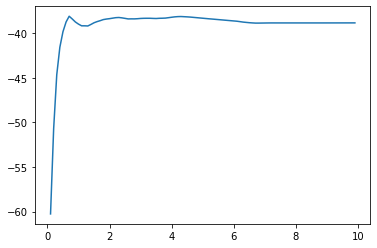

In [123]:
from sklearn.linear_model importLasso
from sklearn.model_selection import cross_val_score

# Lasso regression
lm_l = Lasso(alpha=0.7).fit(X_train, y_train)

print(np.mean(cross_val_score(lm_l, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/10)
    lm_l2 = Lasso(alpha=(i/10))
    error.append(np.mean(cross_val_score(lm_l2, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)))

    
plt.plot(alpha, error)

In [117]:
err = tuple(zip(alpha, error))
max(err, key = lambda x: x[1])

(0.7, -38.075040922071544)

In [84]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))

-40.76074444444445

In [87]:
# tune Random forest with GridSearch
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': range(10,300, 10), 'criterion': ('squared_error', 'absolute_error', 'poisson'), 
              'max_features': ('auto', 'sqrt', 'log2'), 'max_depth': range(1,10,2)}

gs = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ('squared_error', 'absolute_error',
                                       'poisson'),
                         'max_depth': range(1, 10, 2),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [100]:
# RandomForestRegressor(criterion='absolute_error', max_depth=5,
#                       max_features='log2', n_estimators=10)

print(gs.best_score_)
print(gs.best_estimator_)

-32.2308611111111
RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features='log2', n_estimators=10)


In [98]:
# SVR
from sklearn.svm import SVR

svr = SVR()

np.mean(cross_val_score(svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))

-34.41764242253431

In [99]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

gs_svc = GridSearchCV(svr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=2)
gs_svc.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   7.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  11.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   8.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  10.9s
[CV] END ...................C=0.1, gamma=auto, k

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring='neg_mean_absolute_error', verbose=2)

In [101]:
# SVR(C=100)
print(gs_svc.best_score_)
print(gs_svc.best_estimator_)

-33.30709571350865
SVR(C=100)


In [124]:
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)
tpred_svr = gs_svc.best_estimator_.predict(X_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [126]:
from sklearn.metrics import mean_absolute_error
print("Lasso Regression: {}".format(mean_absolute_error(y_test, tpred_lml)))
print("Random Forest: {}".format(mean_absolute_error(y_test, tpred_rf)))
print("SVR: {}".format(mean_absolute_error(y_test, tpred_svr)))
print("RF and SVR: {}".format(mean_absolute_error(y_test, (tpred_svr + tpred_rf)/2)))

Lasso Regression: 58.12651626872975
Random Forest: 33.07105263157895
SVR: 28.686615307470195
RF and SVR: 27.43930653673374
